##Prepare Notebook

In [ ]:
import ee
import geemap
from osgeo import gdal, ogr

In [ ]:
!pip install geedim --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 69.4 MB/s eta 0:00:00


In [ ]:
!pip install rasterio --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Setup the Deep Learning Model

###Loading Libraries

In [ ]:
#Need to install fastai, PIL, typing, and rasterio

from fastai.imports import *
from fastai.torch_imports import *
from packaging.version import parse
from fastai.vision.all import *
from fastcore.transform import Pipeline

from fastai.data.block import CategoryBlock, DataBlock
from fastai.data.core import Datasets
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, IntToFloatTensor, Normalize, RandomSplitter, ToTensor, parent_label

from fastai.torch_core import to_device

from fastai.vision.augment import aug_transforms, Resize, RandomResizedCrop, FlipItem
from fastai.vision.data import ImageBlock, PILImage, get_image_files, imagenet_stats

from PIL import Image
from typing import Tuple

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
from collections import defaultdict
import numpy as np
import subprocess

###Load Training Dataset


In [ ]:
#This is the subset of the main training dataset (provided)
# urlTD = 'https://drive.google.com/uc?id=1GvcP1fr0ZNiPOqgL8aNm7xfXmCu0eTJK'
# !gdown {urlTD}

!unzip -q /content/drive/MyDrive/Workspace/FZ/S1DWdatasetTiny.zip

In [ ]:
input_folder = '/content/S1DWdatasetTiny/images'
output_folder = '/content/S1DWdatasetTiny/images'

In [ ]:
import os

# Specify the directory
input_folder = output_folder

# Iterate over the files
for filename in os.listdir(input_folder):
    # If the filename contains 'S1'
    if 'S1' in filename:
        # Replace 'S1' with 'DW' in the filename
        new_filename = filename.replace('S1', 'DW')
        # Get full paths
        old_file_path = os.path.join(input_folder, filename)
        new_file_path = os.path.join(input_folder, new_filename)
        # Rename the file
        os.rename(old_file_path, new_file_path)


In [ ]:
import os
import numpy as np
import rasterio

# Iterate over the files
for filename in os.listdir(input_folder):
    # Check the file extension
    _, extension = os.path.splitext(filename)
    if extension.lower() == '.tif':
        file_path = os.path.join(input_folder, filename)
        with rasterio.open(file_path, 'r+') as src:
            # Read each band
            for i in range(1, src.count + 1):
                band = src.read(i)
                # Replace NaNs with 0s
                band[np.isnan(band)] = 0
                # Write the modified band back to the file
                src.write(band, i)

###Preparing Deep Learning Model


In [ ]:
#Classes for loading multi-channel bands

def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring"
        if len(channels) == 3:
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1:
            return show_single_channel(self, channel=channels[0], ctx=ctx,
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn, chans=None,  **kwargs) ->None:
        if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
        elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))

    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'

MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create)

def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]
    if scale: im = norm(im, vmin, vmax)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None,
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax


def norm(vals, vmin=None, vmax=None):
    """
    For visualization purposes normalize image with `(vals-vmin)/(vmax-vmin),
    with vals either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01))
    vmax = ifnone(vmax, np.quantile(vals, 0.99))
    return (vals - vmin)/(vmax-vmin)

In [ ]:
#define all band datablock
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None):
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

def _using_attr(f, attr, x):
    return f(getattr(x,attr))

def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [ ]:
#define multichannel data loader

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'],
                    train='train', valid='valid', valid_pct=None, seed=None,
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'],
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    def from_name_func(cls, path, fnames, label_func,
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None,
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv',
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2,
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)

MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [ ]:
#define method to get mask from the labels
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0]

In [ ]:
#define segmentation dataloaders incl. images and masks

class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None,
                         extensions=['.tif'], valid_pct=None, seed=None,
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans),
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
#segmentation classes
codes = ['other', 'water']; codes

['other', 'water']

In [ ]:
#Add Data Augmentations
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize()]

In [ ]:
#Define loss function for the deep learning model
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)

    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)

    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

In [ ]:
cl = CombinedLoss()

###Setup the Global Model

In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Global = TifSegmentationDataLoaders.from_label_funcs(path='/content/S1DWdatasetTiny/images',
                                                   bs = 4,
                                                   codes=codes,
                                                   fnames = get_files('/content/S1DWdatasetTiny/images', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/S1DWdatasetTiny/labels/{o.stem}{o.suffix}'),
                                                   valid_pct=0.2,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Global =  unet_learner(dataLoaderS1Global, resnet34, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 74.6MB/s]


In [ ]:
#load the trained S1 global model (provided)
modelS1Global.load('/content/drive/MyDrive/Workspace/FZ/model_resnet34_10epochs')

##FineTune the global model (if required)

In [ ]:
# !unzip -q /content/drive/MyDrive/Workspace/FZ/trainingDatasetFPS1GEE_256.zip
# !unzip -q /content/drive/MyDrive/UA_Transition/Fritz/SID_19.zip
!unzip -q /content/drive/MyDrive/UA_Transition/Fritz/SID_83.zip
!unzip -q /content/drive/MyDrive/UA_Transition/Fritz/SID_44.zip

In [ ]:
import os
import numpy as np
import rasterio
from multiprocessing import Pool, cpu_count

def process_file(file_path):
    """
    Function to process a single file, replacing NaNs with 0s.
    """
    try:
        with rasterio.open(file_path, 'r+') as src:
            for i in range(1, src.count + 1):
                band = src.read(i)
                band[np.isnan(band)] = 0
                src.write(band, i)
        return f"Processed: {file_path}"
    except Exception as e:
        return f"Error processing {file_path}: {e}"

def main(input_folder):
    """
    Main function to set up multiprocessing pool and distribute the file processing task.
    """
    # List all .tif files in the input folder
    files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.lower().endswith('.tif')]

    # Determine the number of available CPUs and create a pool of workers
    num_processors = cpu_count()
    print(f"Utilizing {num_processors} CPU cores.")
    pool = Pool(processes=num_processors)

    # Map the process_file function to the files, distributing the workload across the pool
    results = pool.map(process_file, files)

    # Close the pool and wait for all processes to finish
    pool.close()
    pool.join()

    # Print results
    for result in results:
        print(result)

if __name__ == "__main__":
    input_folder = '/content/SID_19'
    main(input_folder)
    input_folder = '/content/SID_44'
    main(input_folder)
    input_folder = '/content/SID_83'
    main(input_folder)

Utilizing 8 CPU cores.
Utilizing 8 CPU cores.
Utilizing 8 CPU cores.


##SID19


In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Local = TifSegmentationDataLoaders.from_label_funcs(path='/content/SID_19/S1_256',
                                                   bs = 16,
                                                   codes=codes,
                                                   fnames = get_files('/content/SID_19/S1_256', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/SID_19/DWLabels_256/{o.stem}{o.suffix}'),
                                                   valid_pct=0.1,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Local =  unet_learner(dataLoaderS1Local, resnet34, n_in=3, n_out=2, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

In [ ]:
#load the trained S1 global model (provided)
modelS1Local.load('/content/drive/MyDrive/Workspace/FZ/model_resnet34_10epochs')

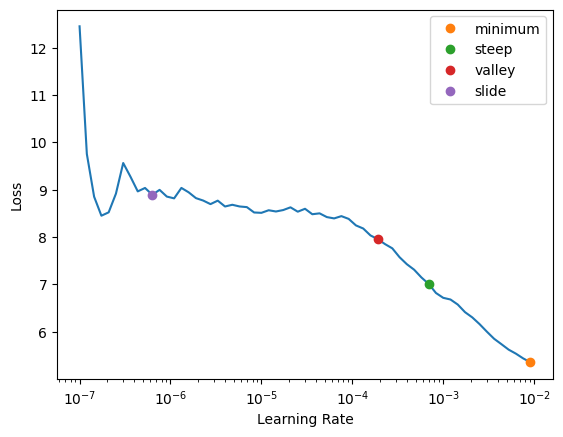

In [ ]:
#find lr
lrs = modelS1Local.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = lrs.valley

In [ ]:
modelS1Local.fit_flat_cos(5, slice(lrs.valley))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,8.189895,1.487988,0.893391,0.943694,00:03
1,8.220465,1.497611,0.893227,0.943602,00:03
2,7.144952,1.411641,0.904994,0.950128,00:03
3,6.304892,1.419065,0.903799,0.949469,00:03
4,5.674954,1.388266,0.907431,0.951469,00:03


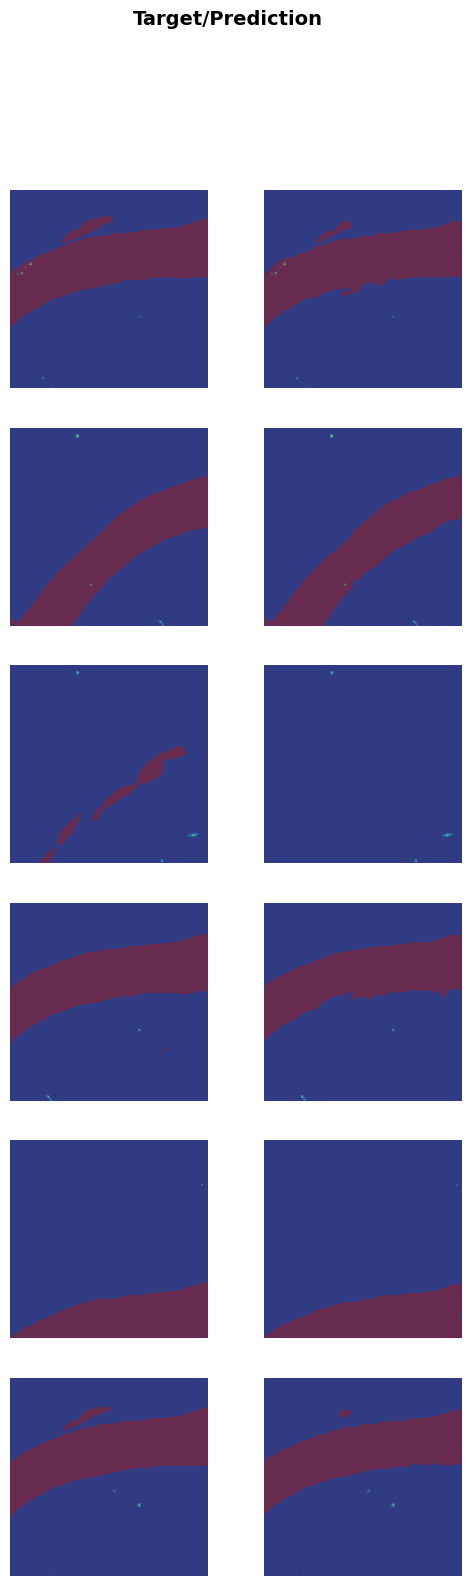

In [ ]:
modelS1Local.show_results()

In [ ]:
modelS1Local.save('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID19')

Path('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID19.pth')

##SID83

In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Local = TifSegmentationDataLoaders.from_label_funcs(path='/content/SID_83/S1_256',
                                                   bs = 16,
                                                   codes=codes,
                                                   fnames = get_files('/content/SID_83/S1_256', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/SID_83/DWLabels_256/{o.stem}{o.suffix}'),
                                                   valid_pct=0.1,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Local =  unet_learner(dataLoaderS1Local, resnet34, n_in=3, n_out=2, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

In [ ]:
#load the trained S1 global model (provided)
modelS1Local.load('/content/drive/MyDrive/Workspace/FZ/model_resnet34_10epochs')

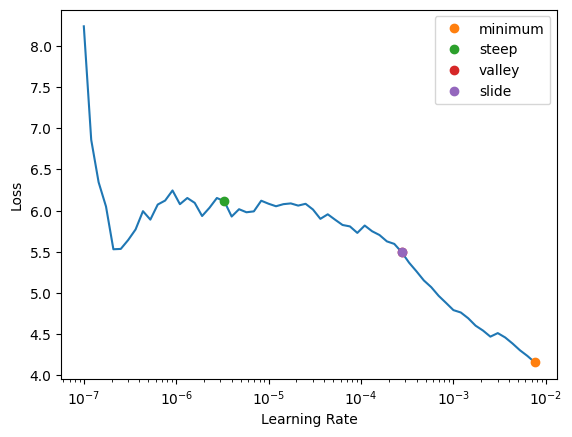

In [ ]:
#find lr
lrs = modelS1Local.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = lrs.valley

In [ ]:
modelS1Local.fit_flat_cos(10, slice(lrs.valley))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,5.116054,0.760978,0.889272,0.941391,00:04
1,4.516410,0.809124,0.884346,0.938624,00:04
2,3.979466,0.780320,0.886251,0.939695,00:04
3,3.383665,0.702808,0.894311,0.944207,00:04
4,2.896917,0.654947,0.899277,0.946968,00:04
5,2.557867,0.611779,0.903751,0.949442,00:04
6,2.317642,0.586994,0.906986,0.951225,00:04
7,2.132700,0.562737,0.910338,0.953065,00:04
8,1.975332,0.548354,0.911894,0.953917,00:04
9,1.847074,0.553156,0.911267,0.953574,00:04


<ipython-input-10-f7eeb5106060>:87: RuntimeWarning: invalid value encountered in divide
  return (vals - vmin)/(vmax-vmin)


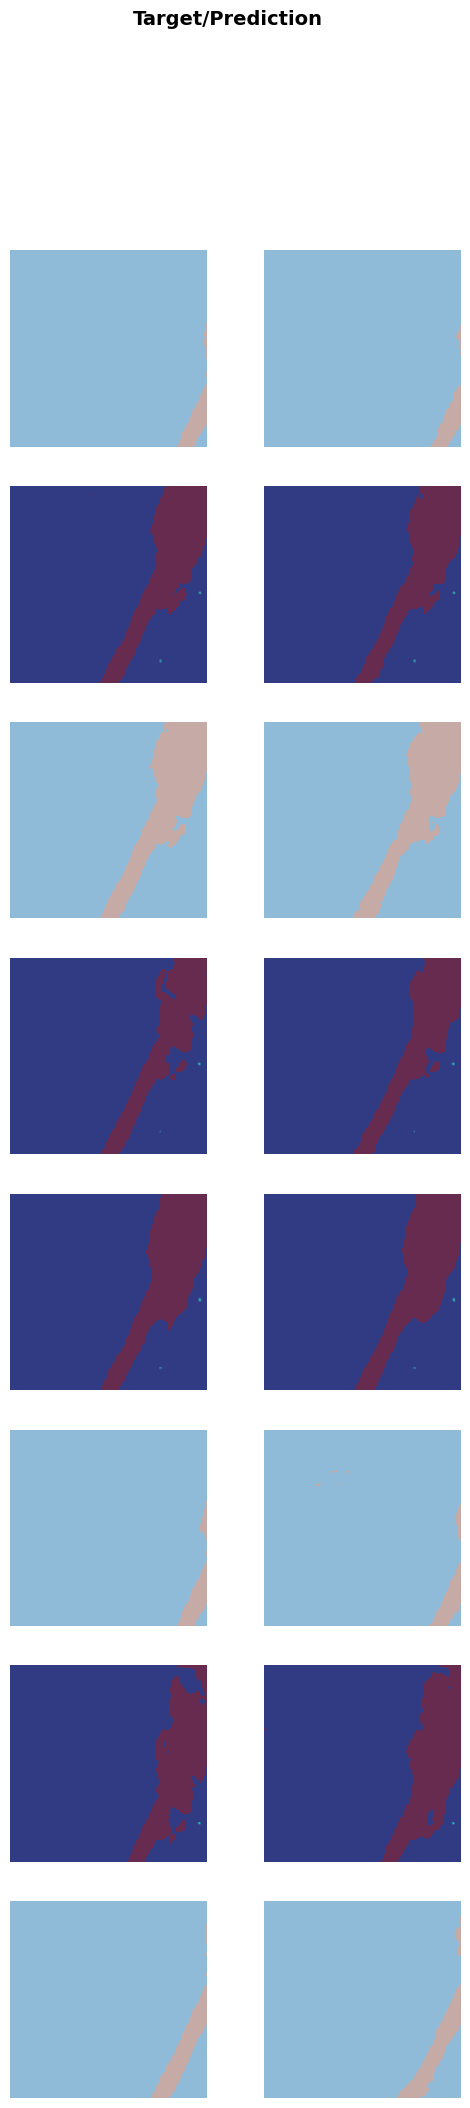

In [ ]:
modelS1Local.show_results()

In [ ]:
modelS1Local.save('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID83')

Path('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID83.pth')

##SID44


In [ ]:
#setting up data loader, check the filepaths
dataLoaderS1Local = TifSegmentationDataLoaders.from_label_funcs(path='/content/SID_44/S1_256',
                                                   bs = 16,
                                                   codes=codes,
                                                   fnames = get_files('/content/SID_44/S1_256', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'/content/SID_44/DWLabels_256/{o.stem}{o.suffix}'),
                                                   valid_pct=0.1,
                                                   seed=42,
                                                   batch_tfms = batch_tfms)

In [ ]:
#setup the deep learning model
modelS1Local =  unet_learner(dataLoaderS1Local, resnet34, n_in=3, n_out=2, metrics = [JaccardCoeff(), Dice()], loss_func=CombinedLoss(), opt_func=ranger, act_cls=Mish)

In [ ]:
#load the trained S1 global model (provided)
modelS1Local.load('/content/drive/MyDrive/Workspace/FZ/model_resnet34_10epochs')

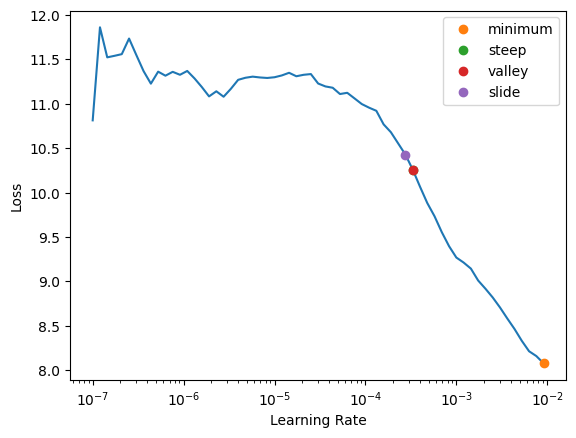

In [ ]:
#find lr
lrs = modelS1Local.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lr = lrs.valley

In [ ]:
modelS1Local.fit_flat_cos(10, slice(lrs.valley))

epoch,train_loss,valid_loss,jaccard_coeff,dice,time
0,5.980913,2.639514,0.771662,0.871116,00:16
1,4.181108,1.918275,0.828680,0.906315,00:17
2,3.319046,1.570270,0.856747,0.922847,00:17
3,2.823756,1.465756,0.865661,0.927994,00:17
4,2.495945,1.326751,0.879179,0.935705,00:17
5,2.244916,1.255188,0.885230,0.939122,00:17
6,2.045461,1.200576,0.890046,0.941825,00:17
7,1.905874,1.157734,0.893828,0.943938,00:17
8,1.797226,1.145874,0.894784,0.944471,00:17
9,1.719458,1.141841,0.895108,0.944651,00:17


<ipython-input-10-f7eeb5106060>:87: RuntimeWarning: invalid value encountered in divide
  return (vals - vmin)/(vmax-vmin)


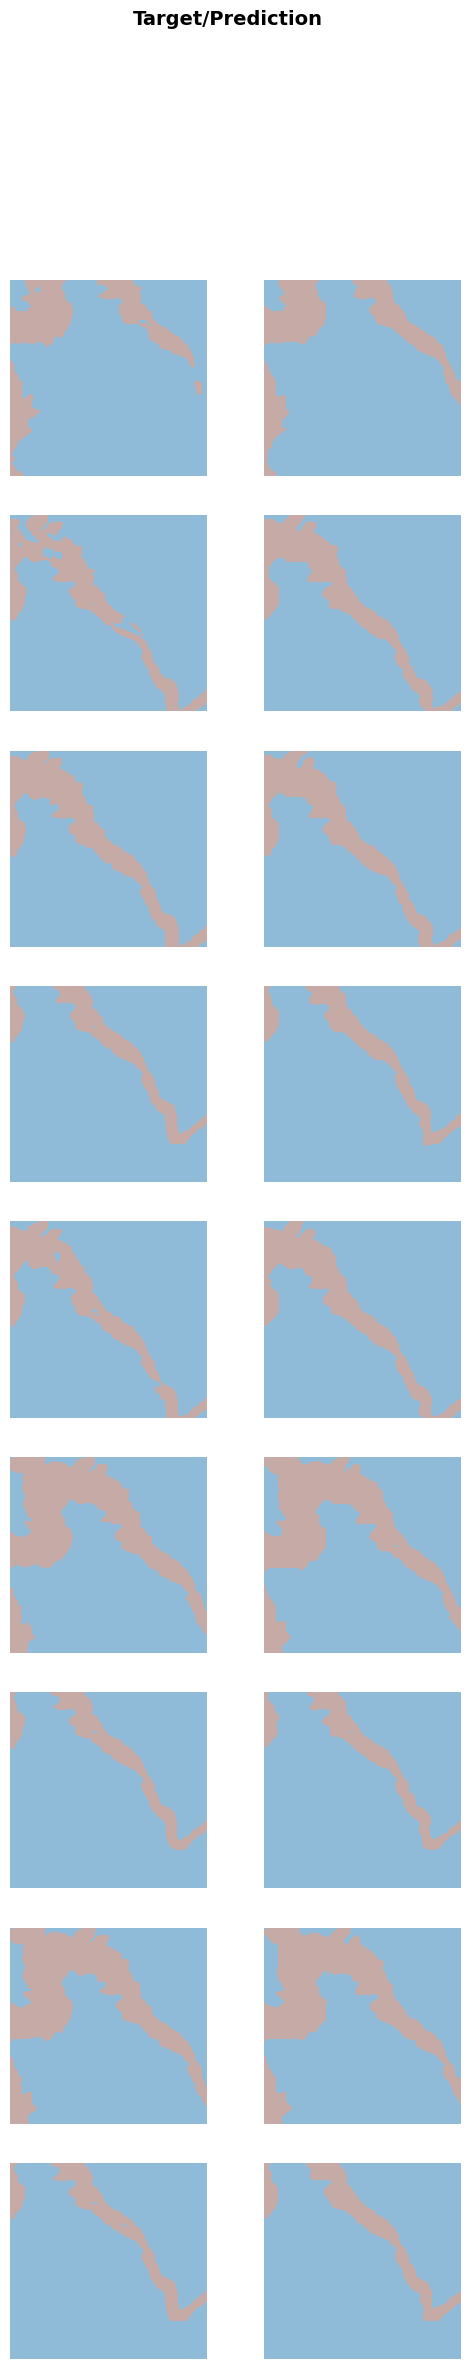

In [ ]:
modelS1Local.show_results()

In [ ]:
modelS1Local.save('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID44')

Path('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID44.pth')

##**Predictions**

###Predict on Local

In [ ]:
toPredictFolder = '/content/SID_44/S1_256'

In [ ]:
#Set the dataset for inference
inferSet = [fn for fn in sorted((Path(toPredictFolder)).glob('**/*')) if fn.is_file()]

In [ ]:
modelS1Local.load('/content/drive/MyDrive/Workspace/FZ/S1GlobalGEE_FT_SID44')

In [ ]:
#Set the dataset for testing
test_dl = modelS1Local.dls.test_dl(inferSet)

In [ ]:
#Get the predictions
preds = modelS1Local.get_preds(dl=test_dl)

In [ ]:
import os
from PIL import Image
import numpy as np

# Create a folder named 'output_images' if it doesn't exist
output_folder = 'predictedImages_SID44'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Your loop for saving images
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy().astype(np.uint8)
    im = Image.fromarray(pred_arg)

    # Extract the image name from its full path
    image_name = str(inferSet[i].name).split('/')[-1]

    # Combine the folder name with the image name
    save_path = os.path.join(output_folder, image_name)

    # Save the image in the specified folder
    im.save(save_path)

print(f"All images have been saved in the '{output_folder}' folder.")

All images have been saved in the 'predictedImages_SID44' folder.


In [ ]:
input_folder = 'predictedImages_SID44'
reference_folder = '/content/SID_44/S1_256'
output_folder = 'waterMapPredictions_SID_44'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over all files in the input directory
for filename in os.listdir(input_folder):
    # Only process .tif files
    _, extension = os.path.splitext(filename)
    if extension.lower() != '.tif':
        continue

    input_filepath = os.path.join(input_folder, filename)
    reference_filepath = os.path.join(reference_folder, filename)

    # Read the reference image
    with rio.open(reference_filepath) as ref_src:
        ref_crs = ref_src.crs
        ref_transform = ref_src.transform

    # Read the original image
    with rio.open(input_filepath) as src:
        array = src.read()
        profile = src.profile

    # Update the profile with the reference CRS and transform
    profile.update({
        'crs': ref_crs,
        'transform': ref_transform,
    })

    # Write the image data back with the updated profile
    output_filepath = os.path.join(output_folder, filename)
    with rio.open(output_filepath, 'w', **profile) as dst:
        dst.write(array)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:

# Step 1: Scan folder and organize files into groups
input_folder = r"/content/waterMapPredictions_SID_44"
output_folder = r"/content/waterMapPredictions_SID_44_mosaic"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

files = os.listdir(input_folder)
file_groups = defaultdict(list)

for file in files:
    if file.endswith('.tif'):
        prefix = "_".join(file.split("_")[:-2])  # Adjust depending on your specific naming pattern
        file_groups[prefix].append(os.path.join(input_folder, file))

# Step 2 and 3: Read files and mosaic them
for prefix, file_group in file_groups.items():
    src_files_to_mosaic = [rio.open(fp) for fp in file_group]

    # Merge function returns a single mosaic array and the transformation info
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Copy the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()

    # Update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})

    # Step 4: Write the mosaic raster to disk
    with rio.open(os.path.join(output_folder, f"{prefix}.tif"), "w", **out_meta) as dest:
        dest.write(mosaic)


###Predict on Global

In [ ]:
#Set the dataset for testing
test_dl = modelS1Global.dls.test_dl(inferSet)

In [ ]:
#Get the predictions
preds = modelS1Global.get_preds(dl=test_dl)

In [ ]:
import os
from PIL import Image
import numpy as np

# Create a folder named 'output_images' if it doesn't exist
output_folder = 'predictedImages_SID19_Global'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Your loop for saving images
for i, pred in enumerate(preds[0]):
    pred_arg = pred.argmax(dim=0).numpy().astype(np.uint8)
    im = Image.fromarray(pred_arg)

    # Extract the image name from its full path
    image_name = str(inferSet[i].name).split('/')[-1]

    # Combine the folder name with the image name
    save_path = os.path.join(output_folder, image_name)

    # Save the image in the specified folder
    im.save(save_path)

print(f"All images have been saved in the '{output_folder}' folder.")

All images have been saved in the 'predictedImages_SID19_Global' folder.


In [ ]:
input_folder = 'predictedImages_SID19_Global'
reference_folder = '/content/SID_19/S1_256'
output_folder = 'waterMapPredictions_SID_19_Global'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate over all files in the input directory
for filename in os.listdir(input_folder):
    # Only process .tif files
    _, extension = os.path.splitext(filename)
    if extension.lower() != '.tif':
        continue

    input_filepath = os.path.join(input_folder, filename)
    reference_filepath = os.path.join(reference_folder, filename)

    # Read the reference image
    with rio.open(reference_filepath) as ref_src:
        ref_crs = ref_src.crs
        ref_transform = ref_src.transform

    # Read the original image
    with rio.open(input_filepath) as src:
        array = src.read()
        profile = src.profile

    # Update the profile with the reference CRS and transform
    profile.update({
        'crs': ref_crs,
        'transform': ref_transform,
    })

    # Write the image data back with the updated profile
    output_filepath = os.path.join(output_folder, filename)
    with rio.open(output_filepath, 'w', **profile) as dst:
        dst.write(array)


In [ ]:

# Step 1: Scan folder and organize files into groups
input_folder = r"/content/waterMapPredictions_SID_19_Global"
output_folder = r"/content/waterMapPredictions_SID_19_Global_mosaic"

# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

files = os.listdir(input_folder)
file_groups = defaultdict(list)

for file in files:
    if file.endswith('.tif'):
        prefix = "_".join(file.split("_")[:-2])  # Adjust depending on your specific naming pattern
        file_groups[prefix].append(os.path.join(input_folder, file))

# Step 2 and 3: Read files and mosaic them
for prefix, file_group in file_groups.items():
    src_files_to_mosaic = [rio.open(fp) for fp in file_group]

    # Merge function returns a single mosaic array and the transformation info
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Copy the metadata
    out_meta = src_files_to_mosaic[0].meta.copy()

    # Update the metadata
    out_meta.update({"driver": "GTiff",
                     "height": mosaic.shape[1],
                     "width": mosaic.shape[2],
                     "transform": out_trans})

    # Step 4: Write the mosaic raster to disk
    with rio.open(os.path.join(output_folder, f"{prefix}.tif"), "w", **out_meta) as dest:
        dest.write(mosaic)


In [ ]:
# zip the mosaicked folder to download
!zip -r /content/waterMapPredictions_SID_19_Global_mosaic.zip /content/waterMapPredictions_SID_19_Global_mosaic
!zip -r /content/waterMapPredictions_SID_19_mosaic.zip /content/waterMapPredictions_SID_19_mosaic

updating: content/waterMapPredictions_SID_19_Global_mosaic/ (stored 0%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12018-03-03_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12022-02-10_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12019-05-21_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12019-03-22_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12019-11-17_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12019-04-27_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12019-06-26_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12018-01-02_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_Global_mosaic/S12023-10-03_SID_19.tif (deflated 99%)
updating: content/waterMapPredictions_SID_19_G

###Delete Folders

In [ ]:
!rm -rf /content/predictedImages_SID44
!rm -rf /content/waterMapPredictions_SID_44
